In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import annotations
from dataclasses import dataclass, field, replace
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Any

In [3]:
from RaTag.datatypes import Run, S2Areas # type: ignore
import RaTag.dataIO as dataIO # type: ignore
import RaTag.config as config # type: ignore
import RaTag.transport as transport # type: ignore
import RaTag.plotting as plotting # type: ignore
import RaTag.transformations as transf # type: ignore
import RaTag.constructors as constructors # type: ignore
import RaTag.analysis as analysis # type: ignore
import RaTag.cuts as cuts # type: ignore
# import RaTag.measurements as meas

In [4]:
def prepare_set(s: SetPmt, run: Run) -> SetPmt:
    s1 = constructors.estimate_s1_from_batches(s, n_batches=1, batch_size=20, flag_plot=False)
    s1 = constructors.set_fields(s1, drift_gap_cm=run.drift_gap, el_gap_cm=run.el_gap, gas_density=run.gas_density)
    s1 = constructors.set_transport_properties(s1, drift_gap_cm=run.drift_gap, transport=None)
    return s1

# Define RUN10

In [5]:
base_dir = Path('/Volumes/KINGSTON/RaTag_data/RUN10_Ra226')
set_path = base_dir / 'FieldScan_Gate100_Anode2000'
wfm_paths = sorted(set_path.glob('*.wfm'))
wfm_paths[:3]

[PosixPath('/Volumes/KINGSTON/RaTag_data/RUN10_Ra226/FieldScan_Gate100_Anode2000/RUN10_20251009_Gate100_Anode2000_P2_1000Wfm.wfm'),
 PosixPath('/Volumes/KINGSTON/RaTag_data/RUN10_Ra226/FieldScan_Gate100_Anode2000/RUN10_20251009_Gate100_Anode2000_P2_1001Wfm.wfm'),
 PosixPath('/Volumes/KINGSTON/RaTag_data/RUN10_Ra226/FieldScan_Gate100_Anode2000/RUN10_20251009_Gate100_Anode2000_P2_1002Wfm.wfm')]

In [6]:
run10 = Run(
    root_directory = base_dir,
    run_id = "RUN10",
    el_field = 2375,            # V/cm
    target_isotope = "Ra226",
    pressure = 2.0,             # bar
    temperature = 297,          # K
    sampling_rate = 5e9,
    el_gap = 0.8,               # cm
    drift_gap = 1.4,            # cm

    width_s2 = 20                # µs 
)

run10 = constructors.populate_run(run10)
run10 = transport.with_gas_density(run10)

run10.gas_density

4.877421222922505e+19

## Adapt data reading for FastFrames

In [7]:
wf = dataIO.load_wfm(str(wfm_paths[3]))
wf.ff

True

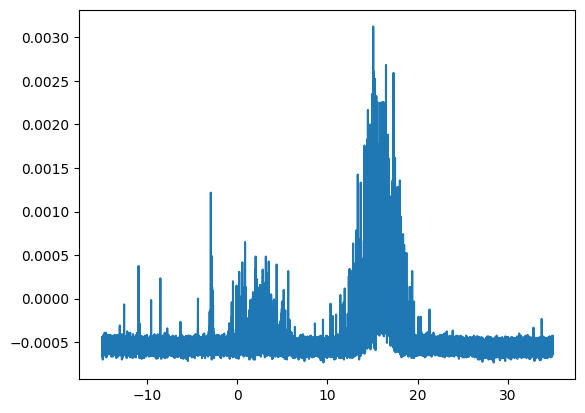

In [8]:
t, V_avg = transf.average_waveform(wfm_paths[:2])
plt.plot(t*1e6, V_avg)

In [9]:
transf.find_s1_in_avg(t, V_avg)

np.int64(60311)

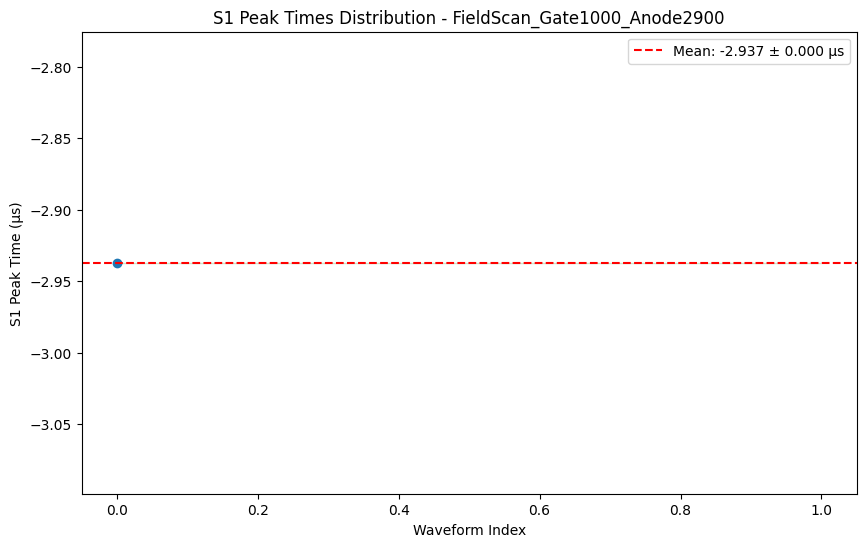

In [10]:
set_transf = constructors.estimate_s1_from_batches(run10.sets[1], n_batches=1)

In [20]:
set_transf.metadata

{'anode': 2900,
 'gate': 1000,
 't_s1': np.float64(-2.937),
 't_s1_std': np.float64(0.0)}

In [12]:
run10 = replace(run10, sets=[prepare_set(s, run10) for s in run10.sets])

In [102]:
IntConfig = config.IntegrationConfig()
IntConfig, run10.width_s2

(IntegrationConfig(bs_threshold=0.8, max_area_s2=100000.0, min_s2_sep=1.0, min_s1_sep=1.0, n_pedestal=2000, ma_window=9, dt=0.0002, integrator=<function integrate_trapz at 0x12bb863a0>),
 20)

In [18]:
IntConfig

IntegrationConfig(bs_threshold=0.8, max_area_s2=100000.0, min_s2_sep=1.0, min_s1_sep=1.0, n_pedestal=2000, ma_window=9, dt=0.0002, integrator=<function integrate_trapz at 0x13ab833a0>)

In [25]:
dataIO.load_wfm(set_transf.source_dir / set_transf.filenames[3])

Waveform(t=array([-1.50000e-05, -1.49998e-05, -1.49996e-05, ...,  3.49994e-05,
        3.49996e-05,  3.49998e-05]), v=array([[-0.0002, -0.0006, -0.0006, ..., -0.0002, -0.0002, -0.0002],
       [-0.0006, -0.0006, -0.0006, ..., -0.0002, -0.0002, -0.0002],
       [-0.0002, -0.0002, -0.0002, ..., -0.0002, -0.0006, -0.0006],
       ...,
       [-0.0002, -0.0002, -0.0002, ..., -0.0002, -0.0002, -0.0002],
       [-0.0002, -0.0002, -0.0002, ..., -0.0006, -0.0006, -0.001 ],
       [-0.001 , -0.001 , -0.001 , ..., -0.0006, -0.0006, -0.0006]]), source='/Volumes/KINGSTON/RaTag_data/RUN10_Ra226/FieldScan_Gate1000_Anode2900/RUN10_20251012_Gate1000_Anode2900_P7_737Wfm.wfm', ff=True, nframes=48)

# Inspect waveform and window

In [67]:
i = 0
j = -1
t_s1 = set_transf.metadata['t_s1']
s2_start = 12.17
s2_end = 19.17

(0, 10)

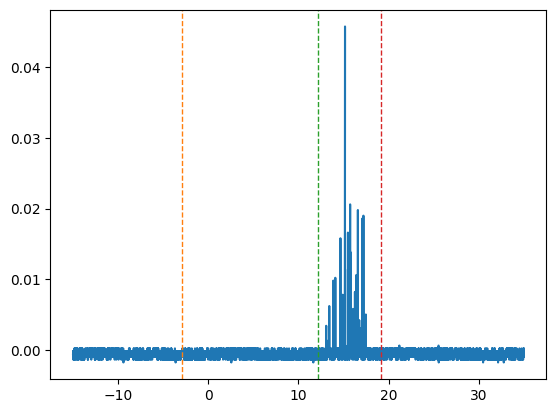

In [78]:
wf = dataIO.load_wfm(wfm_paths[i])
j += 1
Vi = wf.v[j, :]
wf.t *= 1e6  # to us
plt.plot(wf.t, Vi);
plt.axvline(t_s1, color='C1', ls='--', lw=1)
plt.axvline(s2_start, color='C2', ls='--', lw=1)
plt.axvline(s2_end, color='C3', ls='--', lw=1)

i, j

# Test FastFrames at set level

In [13]:
set_transf.filenames[3]

'RUN10_20251012_Gate1000_Anode2900_P7_737Wfm.wfm'

In [79]:
results_set100 = transf.s2_area_pipeline(dataIO.load_wfm(set_transf.source_dir / set_transf.filenames[3]), t_window = (12.17, 19.17), bs_threshold=0.8, dt = 2e-4)

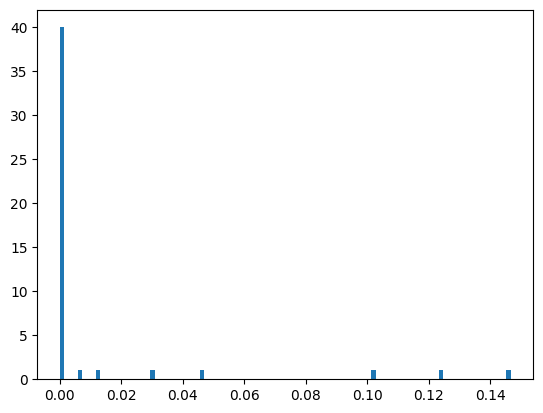

In [80]:
res_cuts = results_set100[results_set100 < 10]
plt.hist(res_cuts, bins=100, );

In [81]:
results_set100 = analysis.integrate_set_s2(run10.sets[0], t_window = (12.17, 19.17), bs_threshold=0.8, dt = 2e-4)

In [82]:
results_set100 = replace(results_set100, areas=results_set100.areas.flatten())

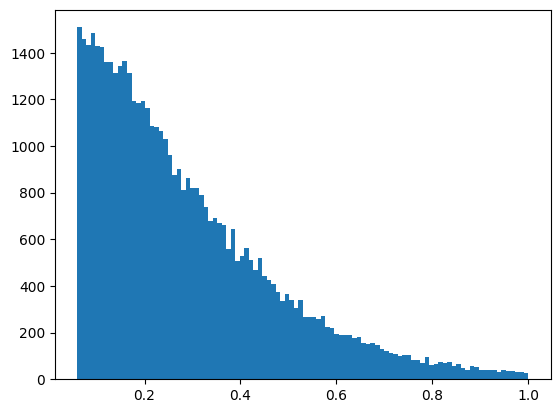

In [83]:

res_cuts = results_set100.areas[(results_set100.areas > 0.06) & (results_set100.areas < 1)]
plt.hist(res_cuts, bins=100, );

S2Areas(source_dir=FieldScan_Gate050_Anode1950, n_areas=86400, method=s2_area_pipeline)

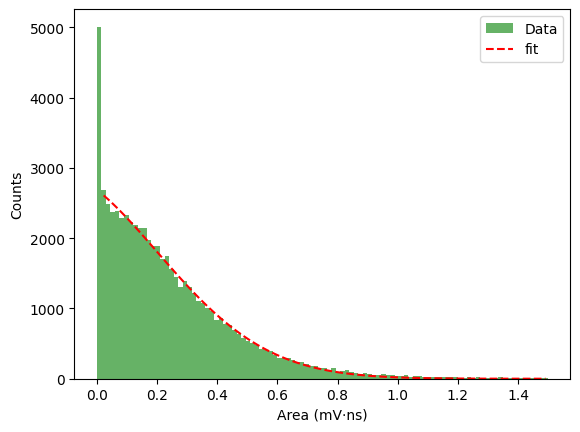

In [86]:
analysis.fit_set_s2(results_set100, bin_cuts=(0, 1.5), flag_plot=True)

In [87]:
dataIO.store_s2area(results_set100)

In [89]:
run10.sets[0].time_drift

np.float64(19.975595667979597)

In [32]:
dataIO.load_s2area(run9.sets[0])

S2Areas(source_dir=FieldScan_Gate100_Anode2000, n_areas=96048, method=loaded_from_npy)

In [33]:
transf.average_waveform([wfm_paths[0]])

(array([-1.50000e-05, -1.49998e-05, -1.49996e-05, ...,  3.49994e-05,
         3.49996e-05,  3.49998e-05]),
 array([-0.0003    , -0.0003    , -0.000325  , ..., -0.00036667,
        -0.00036667, -0.00035   ]))

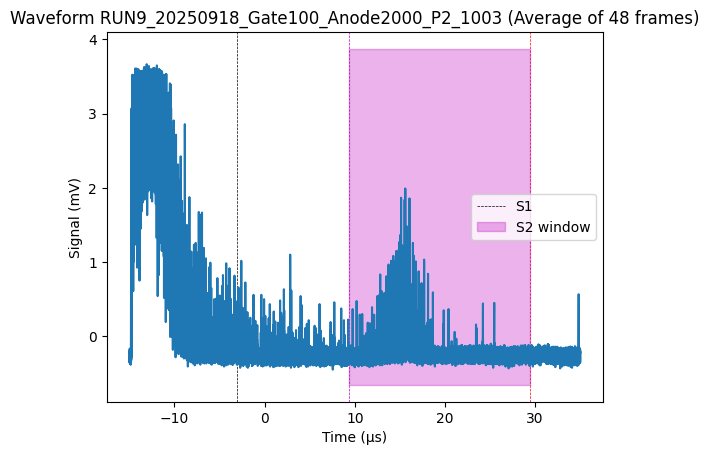

In [34]:
plotting.plot_winS2_wf(wf, t_s1=run9.sets[0].metadata['t_s1'], 
                       time_drift=run9.sets[0].time_drift, width_s2=run9.width_s2,
                       ts2_tol=-2.7)

# Test FF at run level

(<Figure size 1000x4000 with 10 Axes>,
 array([<Axes: title={'center': 'Set FieldScan_Gate050_Anode1950'}, xlabel='Time (µs)', ylabel='Signal (mV)'>,
        <Axes: title={'center': 'Set FieldScan_Gate1000_Anode2900'}, xlabel='Time (µs)', ylabel='Signal (mV)'>,
        <Axes: title={'center': 'Set FieldScan_Gate100_Anode2000'}, xlabel='Time (µs)', ylabel='Signal (mV)'>,
        <Axes: title={'center': 'Set FieldScan_Gate1200_Anode3100'}, xlabel='Time (µs)', ylabel='Signal (mV)'>,
        <Axes: title={'center': 'Set FieldScan_Gate1500_Anode3400'}, xlabel='Time (µs)', ylabel='Signal (mV)'>,
        <Axes: title={'center': 'Set FieldScan_Gate1800_Anode3700'}, xlabel='Time (µs)', ylabel='Signal (mV)'>,
        <Axes: title={'center': 'Set FieldScan_Gate200_Anode2100'}, xlabel='Time (µs)', ylabel='Signal (mV)'>,
        <Axes: title={'center': 'Set FieldScan_Gate400_Anode2300'}, xlabel='Time (µs)', ylabel='Signal (mV)'>,
        <Axes: title={'center': 'Set FieldScan_Gate600_Anode2500'}, x

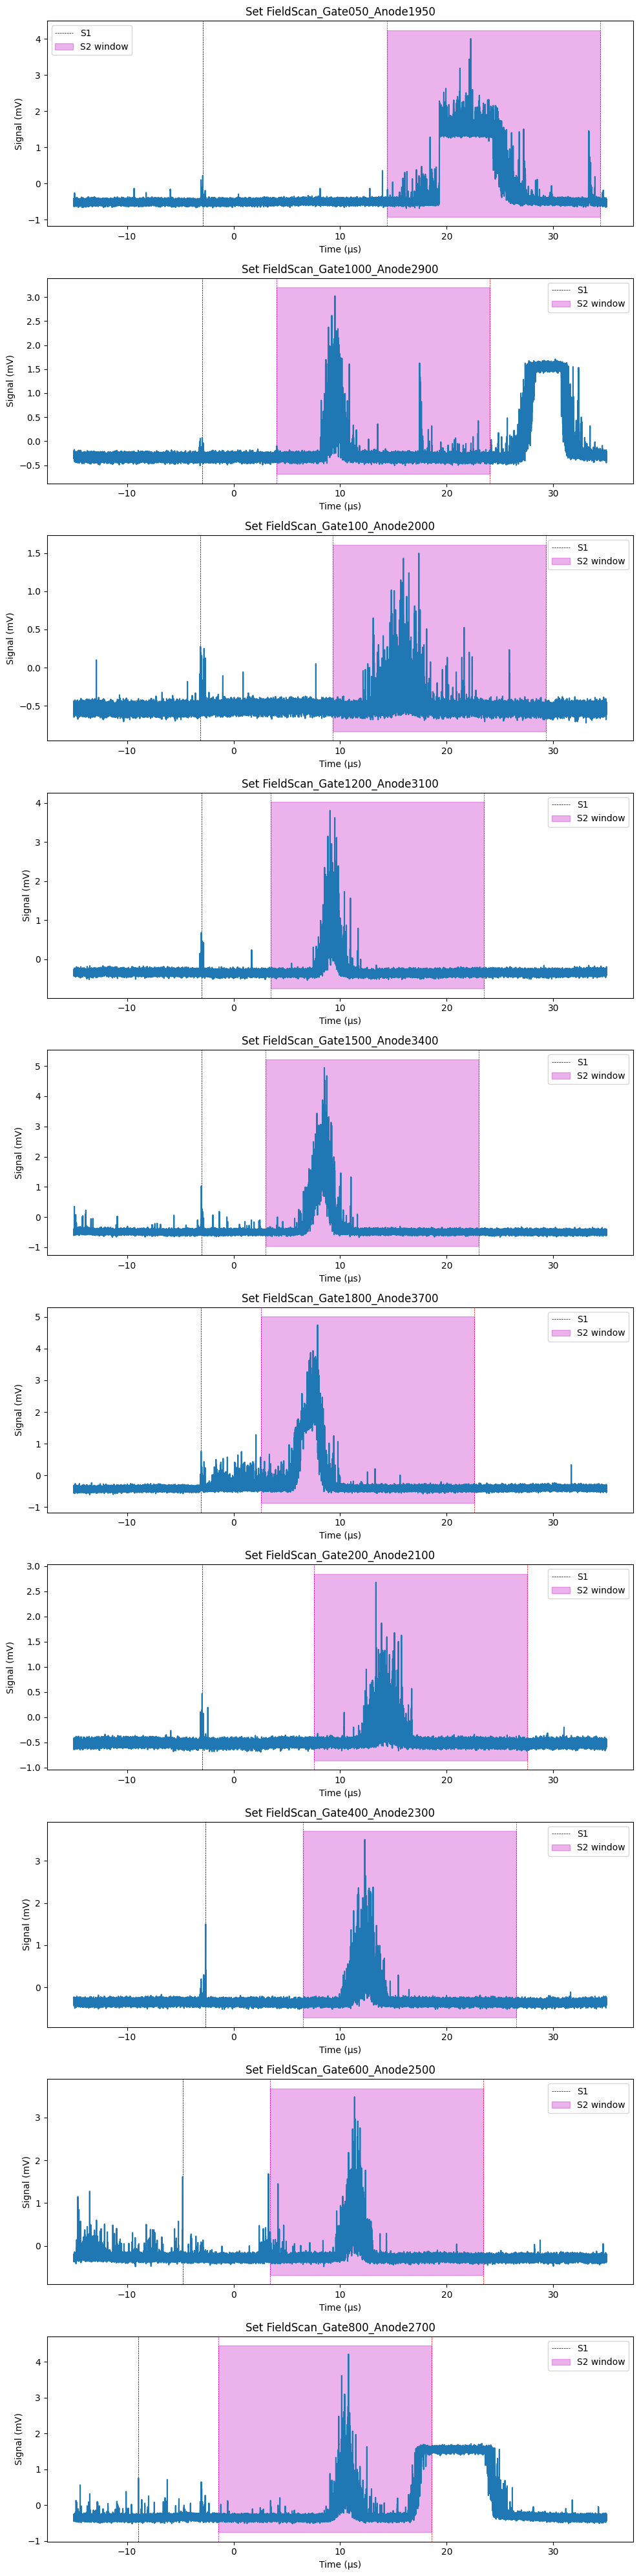

In [88]:
plotting.plot_run_winS2(run10, ts2_tol=-2.7)

In [90]:
run10.width_s2

20

In [99]:
run10.sets[8].metadata['t_s1'] = -3.053
run10.sets[9].metadata['t_s1'] = -3.053

In [100]:
# range_sets = slice(4, 7)
range_sets = None
sets_to_process = run10.sets[range_sets] if range_sets is not None else run10.sets
for set_pmt in sets_to_process:
    print(set_pmt.source_dir, set_pmt.metadata['t_s1'], set_pmt.time_drift)

/Volumes/KINGSTON/RaTag_data/RUN10_Ra226/FieldScan_Gate050_Anode1950 -2.891 19.975595667979597
/Volumes/KINGSTON/RaTag_data/RUN10_Ra226/FieldScan_Gate1000_Anode2900 -2.937 9.665852928855207
/Volumes/KINGSTON/RaTag_data/RUN10_Ra226/FieldScan_Gate100_Anode2000 -3.105 15.137548167034852
/Volumes/KINGSTON/RaTag_data/RUN10_Ra226/FieldScan_Gate1200_Anode3100 -3.026 9.23208098393437
/Volumes/KINGSTON/RaTag_data/RUN10_Ra226/FieldScan_Gate1500_Anode3400 -3.025 8.722819400151838
/Volumes/KINGSTON/RaTag_data/RUN10_Ra226/FieldScan_Gate1800_Anode3700 -3.045 8.331042205252169
/Volumes/KINGSTON/RaTag_data/RUN10_Ra226/FieldScan_Gate200_Anode2100 -2.952 13.209800817948338
/Volumes/KINGSTON/RaTag_data/RUN10_Ra226/FieldScan_Gate400_Anode2300 -2.62 11.834509826932996
/Volumes/KINGSTON/RaTag_data/RUN10_Ra226/FieldScan_Gate600_Anode2500 -3.053 10.90498318913292
/Volumes/KINGSTON/RaTag_data/RUN10_Ra226/FieldScan_Gate800_Anode2700 -3.053 10.208011631201


In [103]:
results_run10 = analysis.integrate_run_s2(run10, ts2_tol = -2.7, 
                                         range_sets = slice(0, 2),
                                         integration_config=IntConfig)

Processing set /Volumes/KINGSTON/RaTag_data/RUN10_Ra226/FieldScan_Gate050_Anode1950 with t_window: (np.float64(14.3845956679796), np.float64(34.384595667979596))
Processing set /Volumes/KINGSTON/RaTag_data/RUN10_Ra226/FieldScan_Gate1000_Anode2900 with t_window: (np.float64(4.0288529288552075), np.float64(24.02885292885521))


In [104]:
results_run102 = analysis.integrate_run_s2(run10, ts2_tol = -2.7, 
                                         range_sets = slice(2, 4),
              
                                         integration_config=IntConfig)

Processing set /Volumes/KINGSTON/RaTag_data/RUN10_Ra226/FieldScan_Gate100_Anode2000 with t_window: (np.float64(9.332548167034851), np.float64(29.33254816703485))
Processing set /Volumes/KINGSTON/RaTag_data/RUN10_Ra226/FieldScan_Gate1200_Anode3100 with t_window: (np.float64(3.5060809839343703), np.float64(23.50608098393437))


In [105]:
results_run104 = analysis.integrate_run_s2(run10, ts2_tol = -2.7, 
                                         range_sets = slice(4, 7),
                                         integration_config=IntConfig)

Processing set /Volumes/KINGSTON/RaTag_data/RUN10_Ra226/FieldScan_Gate1500_Anode3400 with t_window: (np.float64(2.9978194001518377), np.float64(22.997819400151837))
Processing set /Volumes/KINGSTON/RaTag_data/RUN10_Ra226/FieldScan_Gate1800_Anode3700 with t_window: (np.float64(2.586042205252169), np.float64(22.58604220525217))
Processing set /Volumes/KINGSTON/RaTag_data/RUN10_Ra226/FieldScan_Gate200_Anode2100 with t_window: (np.float64(7.557800817948338), np.float64(27.557800817948337))


In [106]:
results_run106 = analysis.integrate_run_s2(run10, ts2_tol = -2.7, 
                                         range_sets = slice(7, 10),
                                         integration_config=IntConfig)

Processing set /Volumes/KINGSTON/RaTag_data/RUN10_Ra226/FieldScan_Gate400_Anode2300 with t_window: (np.float64(6.514509826932996), np.float64(26.514509826932997))
Processing set /Volumes/KINGSTON/RaTag_data/RUN10_Ra226/FieldScan_Gate600_Anode2500 with t_window: (np.float64(5.15198318913292), np.float64(25.15198318913292))
Processing set /Volumes/KINGSTON/RaTag_data/RUN10_Ra226/FieldScan_Gate800_Anode2700 with t_window: (np.float64(4.455011631201), np.float64(24.455011631201))


In [ ]:
results_run92

{'FieldScan_Gate300_Anode2200': S2Areas(source_dir=FieldScan_Gate300_Anode2200, n_areas=96000, method=s2_area_pipeline),
 'FieldScan_Gate400_Anode2300': S2Areas(source_dir=FieldScan_Gate400_Anode2300, n_areas=96000, method=s2_area_pipeline)}

In [107]:
results10 = {**results_run10, **results_run102, **results_run104, **results_run106}

In [115]:
fitted = analysis.fit_run_s2(results10, fit_config = config.FitConfig(bin_cuts=(0, 10), exclude_index=4))

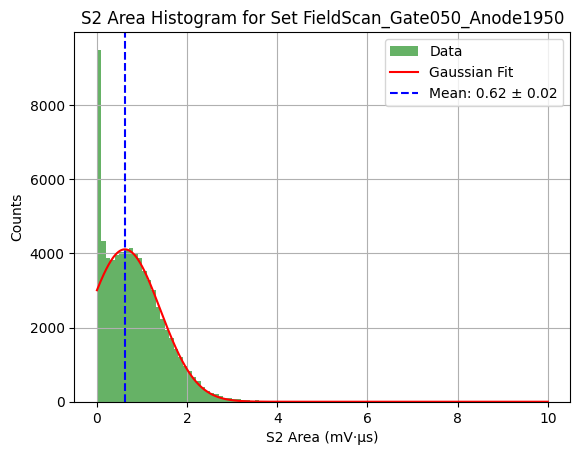

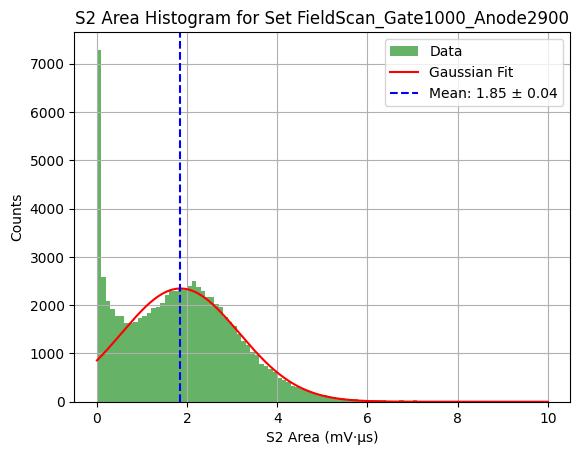

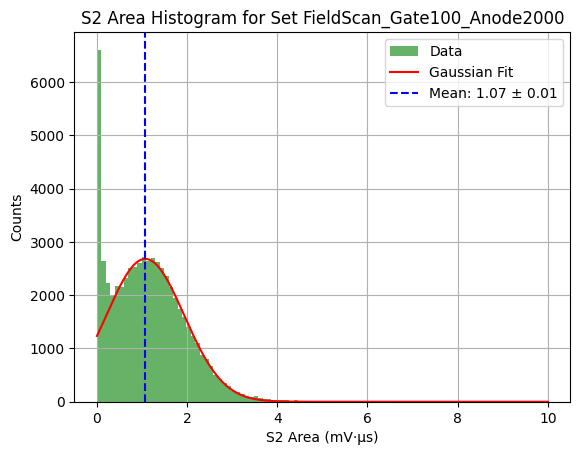

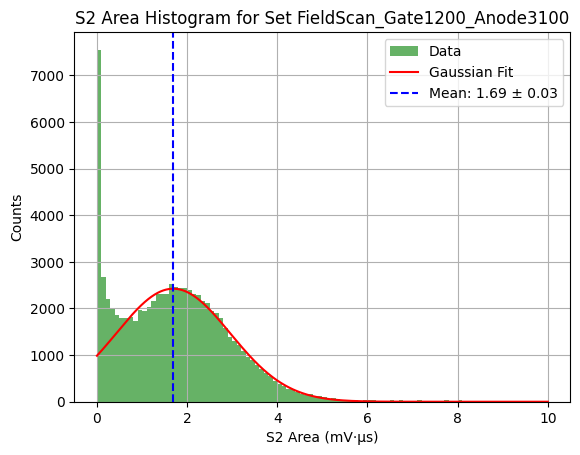

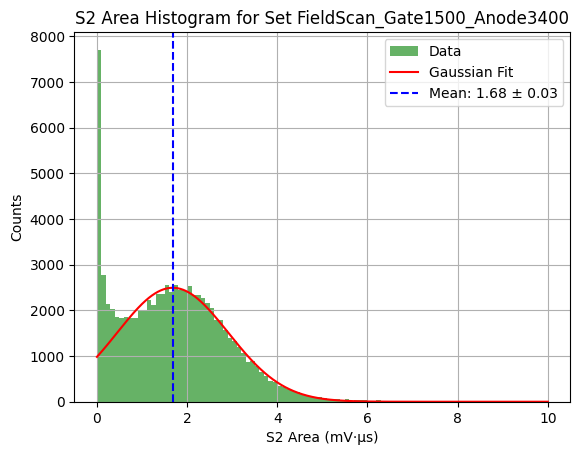

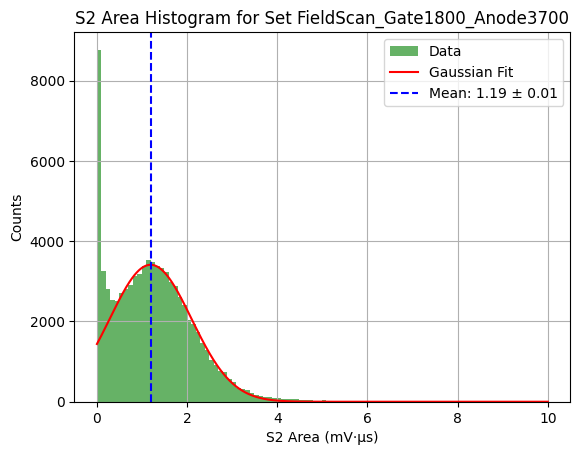

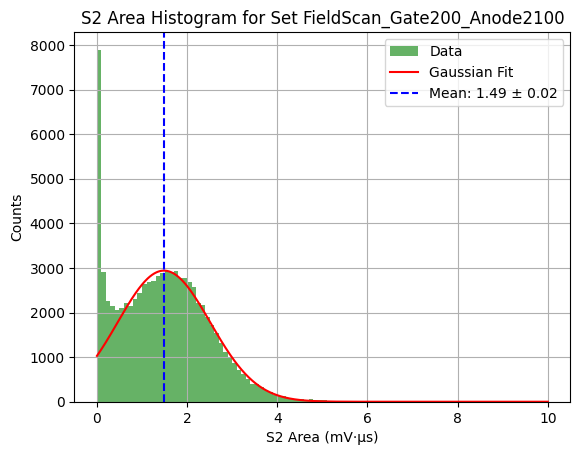

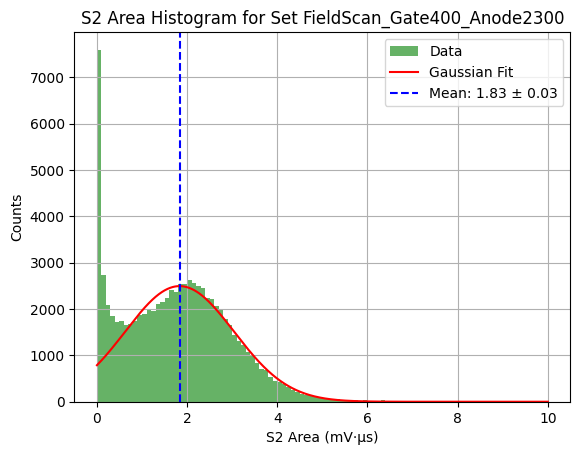

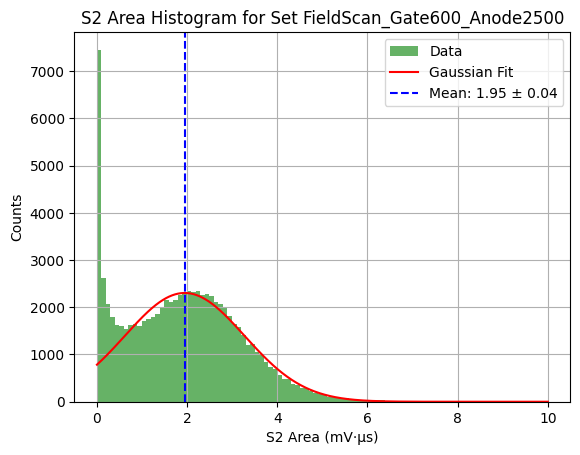

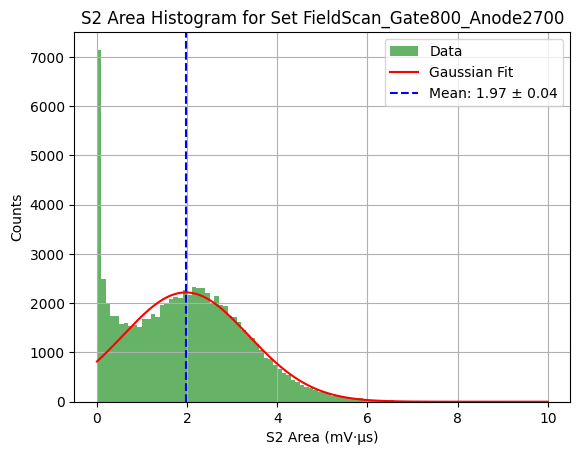

In [119]:
for set_id, fit in fitted.items():
    plotting.plot_hist_fit(fit, bin_cuts=(0, 10), )

In [111]:
run8 = replace(run8, run_id = 'RUN8')

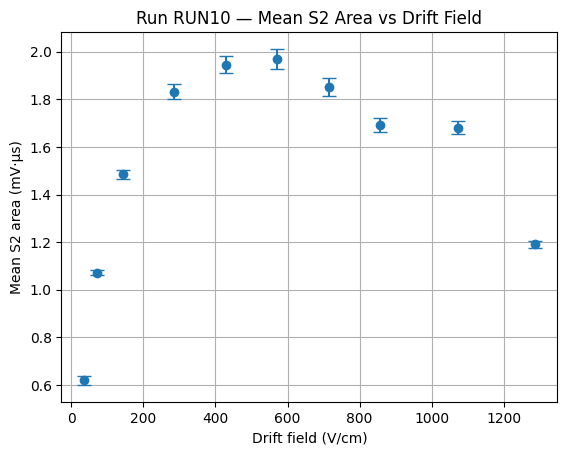

In [117]:
plotting.plot_s2_vs_drift(fitted=fitted, run=run10)

In [120]:
run10.el_field

2375